In [1]:
# Importação das bibliotecas necessárias
import numpy as np
import heapq
import matplotlib.pyplot as plt


In [2]:
#Função de Simulação do Sistema RDSI

def simular_sistema_rdsi(
    # Parâmetros do sistema
    M1, M2, S, V1, V2,
    # Parâmetros de tráfego
    lambda1_terminal, lambda2_terminal, mu1, mu2,
    # Parâmetro da simulação
    total_partidas_desejado=100000
):
    """
    Simula o sistema RDSI para obter as estatísticas finais de bloqueio.
    A coleta de dados históricos foi removida para simplificação.
    """
    # --- Estado inicial e contadores ---
    t = 0.0
    chamadas_telefone_ativas = 0
    chamadas_fax_ativas = 0
    fila_de_eventos = []
    tentativas_telefone, bloqueios_telefone = 0, 0
    tentativas_fax, bloqueios_fax = 0, 0
    total_partidas = 0

    # --- Agendamento dos eventos iniciais ---
    for i in range(M1):
        heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda1_terminal), "CHEGADA", "TELEFONE", i))
    for i in range(M2):
        heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda2_terminal), "CHEGADA", "FAX", i))

    # --- Loop principal da simulação ---
    while total_partidas < total_partidas_desejado:
        if not fila_de_eventos: break
        tempo_evento, tipo_evento, tipo_chamada, id_terminal = heapq.heappop(fila_de_eventos)
        t = tempo_evento

        if tipo_evento == "CHEGADA":
            if tipo_chamada == "TELEFONE":
                tentativas_telefone += 1
                canais_ocupados = (chamadas_telefone_ativas * V1) + (chamadas_fax_ativas * V2)
                if canais_ocupados + V1 <= S:
                    chamadas_telefone_ativas += 1
                    heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / mu1), "PARTIDA", "TELEFONE", id_terminal))
                else:
                    bloqueios_telefone += 1
                    heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda1_terminal), "CHEGADA", "TELEFONE", id_terminal))
            elif tipo_chamada == "FAX":
                tentativas_fax += 1
                canais_ocupados = (chamadas_telefone_ativas * V1) + (chamadas_fax_ativas * V2)
                if canais_ocupados + V2 <= S:
                    chamadas_fax_ativas += 1
                    heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / mu2), "PARTIDA", "FAX", id_terminal))
                else:
                    bloqueios_fax += 1
                    heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda2_terminal), "CHEGADA", "FAX", id_terminal))
        elif tipo_evento == "PARTIDA":
            total_partidas += 1
            if tipo_chamada == "TELEFONE":
                chamadas_telefone_ativas -= 1
                heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda1_terminal), "CHEGADA", "TELEFONE", id_terminal))
            elif tipo_chamada == "FAX":
                chamadas_fax_ativas -= 1
                heapq.heappush(fila_de_eventos, (t + np.random.exponential(1 / lambda2_terminal), "CHEGADA", "FAX", id_terminal))

    # --- Montagem do dicionário de resultados ---
    resultados_finais = {
        'P_bloqueio_telefone': bloqueios_telefone / tentativas_telefone if tentativas_telefone > 0 else 0,
        'P_bloqueio_fax': bloqueios_fax / tentativas_fax if tentativas_fax > 0 else 0
    }

    # Imprimir os resultados numéricos
    print(f"Probabilidade de Bloqueio Simulada para Telefone: {resultados_finais['P_bloqueio_telefone']:.4f}")
    print(f"Probabilidade de Bloqueio Simulada para FAX: {resultados_finais['P_bloqueio_fax']:.4f}")

    return resultados_finais


In [4]:
# Função para Plotar o Gráfico de Comparação

def plotar_comparacao_final(resultado_sim, pb_teorico_tel, pb_teorico_fax):
    """Gera o gráfico de barras comparando os resultados finais."""
    labels = ['Telefone', 'FAX']
    valores_sim = [resultado_sim['P_bloqueio_telefone'], resultado_sim['P_bloqueio_fax']]
    valores_teoricos = [pb_teorico_tel, pb_teorico_fax]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, valores_sim, width, label='Simulação', color='royalblue')
    rects2 = ax.bar(x + width/2, valores_teoricos, width, label='Teórico', color='darkorange')

    ax.set_ylabel('Probabilidade de Bloqueio (Pb)')
    ax.set_title('Comparação Final: Probabilidade de Bloqueio Simulada vs. Teórica')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.4f')
    ax.bar_label(rects2, padding=3, fmt='%.4f')

    fig.tight_layout()


Iniciando simulação para gerar o gráfico final...
Probabilidade de Bloqueio Simulada para Telefone: 0.0397
Probabilidade de Bloqueio Simulada para FAX: 0.1561
Simulação concluída. Gerando gráfico...


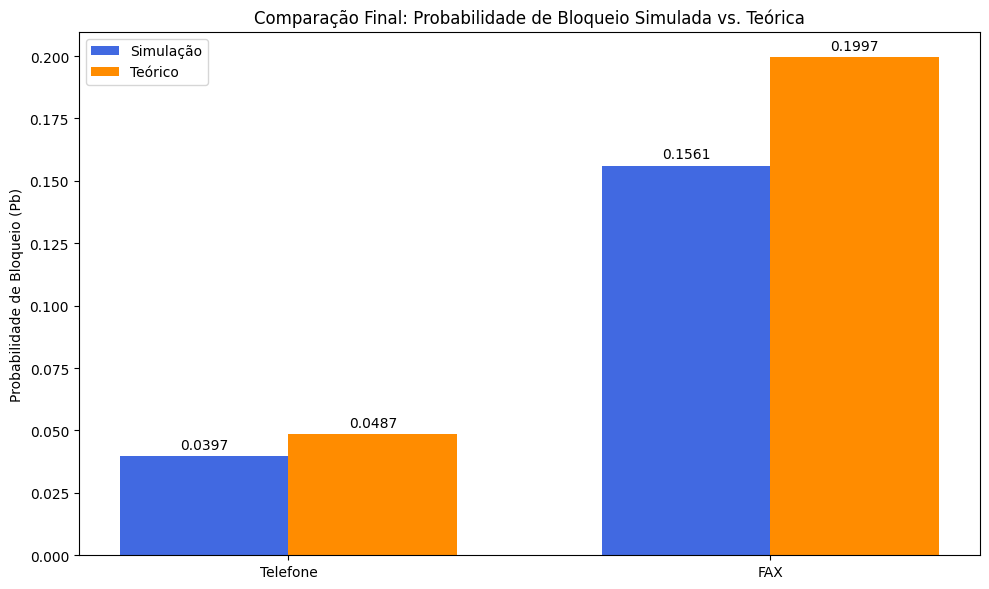

In [5]:
# --- Bloco Principal de Execução ---
if __name__ == "__main__":

    # Parâmetros de Entrada
    M1_param, M2_param, S_param, V1_param, V2_param = 5, 3, 3, 1, 2
    lambda1_total, ts1_min = 4.0, 6.0
    lambda2_total, ts2_min = 1.0, 12.0

    # Conversão para taxas
    lambda1_term = lambda1_total / M1_param
    lambda2_term = lambda2_total / M2_param
    mu1_param = 60.0 / ts1_min
    mu2_param = 60.0 / ts2_min

    # Valores teóricos para o gráfico
    pb_teorico_telefone = 0.0487
    pb_teorico_fax = 0.1997

    # Execução da Simulação
    print("Iniciando simulação para gerar o gráfico final...")
    resultados_finais = simular_sistema_rdsi(
        M1=M1_param, M2=M2_param, S=S_param, V1=V1_param, V2=V2_param,
        lambda1_terminal=lambda1_term, lambda2_terminal=lambda2_term,
        mu1=mu1_param, mu2=mu2_param
    )
    print("Simulação concluída. Gerando gráfico...")

    # Geração do Gráfico de Comparação
    plotar_comparacao_final(resultados_finais, pb_teorico_telefone, pb_teorico_fax)

    # Exibe o gráfico
    plt.show()
